%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,8)
import pylab as plt
from astrometry.libkd.spherematch import *
from astrometry.util.fits import *
import numpy as np
from astrometry.util.starutil_numpy import *
from astrometry.util.plotutils import *
from glob import glob
from collections import Counter

In [2]:
# pip install emcee
import emcee

In [3]:
T70 = merge_tables([fits_table(fn) for fn in glob('/global/cscratch1/sd/dstn/cosmos-dr7-70/tractor/*/tractor-*.fits')])

In [4]:
print(len(T70))
T70.cut(T70.brick_primary)
print(len(T70))
T70.cut((T70.flux_ivar_r > 0) * (T70.flux_ivar_g > 0) * (T70.flux_ivar_z > 0))
print(len(T70), 'measured g,r,z fluxes')

52078
51190
46947 measured g,r,z fluxes


In [5]:
Counter(T70.type)

Counter({'PSF ': 15121,
         'EXP ': 4794,
         'DEV ': 2489,
         'REX ': 24438,
         'COMP': 105})

/global/common/software/desi/cori/desiconda/20180512-1.2.5-img/conda/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':
/global/common/software/desi/cori/desiconda/20180512-1.2.5-img/conda/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':


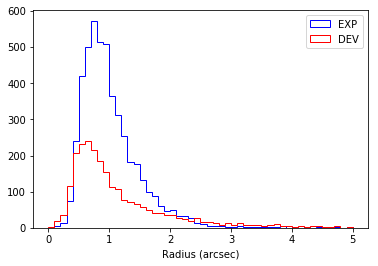

In [6]:
T70.r_mag = -2.5 * (np.log10(T70.flux_r) - 9)
T70.r_sn = T70.flux_r * np.sqrt(T70.flux_ivar_r)
E70 = T70[T70.type == 'EXP ']
D70 = T70[T70.type == 'DEV ']
plt.hist(E70.shapeexp_r, range=(0,5), bins=50, histtype='step', color='b', label='EXP')
plt.hist(D70.shapedev_r, range=(0,5), bins=50, histtype='step', color='r', label='DEV');
plt.xlabel('Radius (arcsec)')
plt.legend();

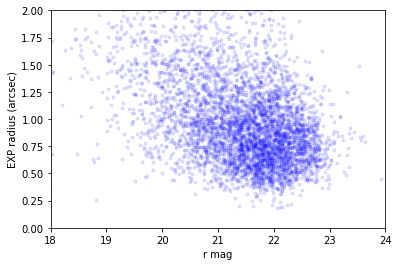

In [7]:
plt.plot(E70.r_mag, E70.shapeexp_r, 'b.', alpha=0.1);
plt.ylim(0,2);
plt.xlim(18,24);
plt.xlabel('r mag')
plt.ylabel('EXP radius (arcsec)');

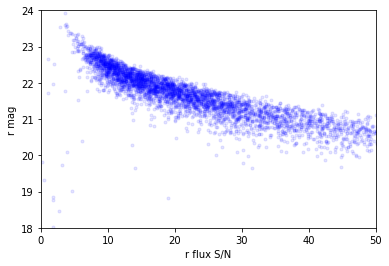

In [8]:
plt.plot(E70.r_sn, E70.r_mag, 'b.', alpha=0.1);
plt.ylim(18,24);
plt.xlim(0,50);
plt.xlabel('r flux S/N')
plt.ylabel('r mag');

In [37]:
# EXP radius in range [0.9, 1.0]
#E701 = E70[(E70.shapeexp_r > 0.9) * (E70.shapeexp_r < 1.0)]
# [0.9, 1.1]
E701 = E70[(E70.shapeexp_r > 0.9) * (E70.shapeexp_r < 1.1)]
len(E701)

875

In [11]:
# Read catalogs for COSMOS subset 71
T71 = merge_tables([fits_table(fn) for fn in glob('/global/cscratch1/sd/dstn/cosmos-dr7-71/tractor/*/tractor-*.fits')])

In [12]:
print(len(T71))
T71.cut(T71.brick_primary)
print(len(T71))
T71.cut((T71.flux_ivar_r > 0) * (T71.flux_ivar_g > 0) * (T71.flux_ivar_z > 0))
print(len(T71))
Counter(T71.type)
T71.r_mag = -2.5 * (np.log10(T71.flux_r) - 9)
T71.r_sn = T71.flux_r * np.sqrt(T71.flux_ivar_r)

51232
50356
46528


/global/common/software/desi/cori/desiconda/20180512-1.2.5-img/conda/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10
/global/common/software/desi/cori/desiconda/20180512-1.2.5-img/conda/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in log10


In [13]:
# Match to subset 70 EXP galaxies of size ~1"
I,J,d = match_radec(E701.ra, E701.dec, T71.ra, T71.dec, 1.0/3600., nearest=True)
len(I)

853

In [14]:
Counter(T71.type[J])

Counter({'EXP ': 667, 'REX ': 143, 'DEV ': 36, 'COMP': 1, 'PSF ': 6})

In [15]:
# Cut to galaxies classed as EXP in subset 71 also.
K = np.flatnonzero(T71.type[J] == 'EXP ')
M701 = E701[I[K]]
M711 = T71[J[K]]
len(K)

667

In [27]:
#plt.plot(M701.shapeexp_r, M701.r_mag, 'b.')
#plt.plot(M711.shapeexp_r, M711.r_mag, 'g.')

In [16]:
# shape ratio
sr = M701.shapeexp_r / M711.shapeexp_r
# flux ratio
fr = M701.flux_r / M711.flux_r
kk = np.flatnonzero((sr < 1.3) * (fr > 0.7) * (fr < 1.4))

In [17]:
# Find Gaussian covariance and compute major axis direction.
C = np.cov(np.vstack((sr[kk]-1,fr[kk]-1)))
print(C)
U,S,V = np.linalg.svd(C)
print('U', U)
print('S', S)
print('V', V)
dx = U[0][0]
dy = U[0][1]
dx,dy

[[ 0.01001424  0.00541227]
 [ 0.00541227  0.00883383]]
U [[-0.74444838 -0.66768002]
 [-0.66768002  0.74444838]]
S [ 0.01486839  0.00397968]
V [[-0.74444838 -0.66768002]
 [-0.66768002  0.74444838]]


(-0.74444837913282436, -0.66768002127254811)

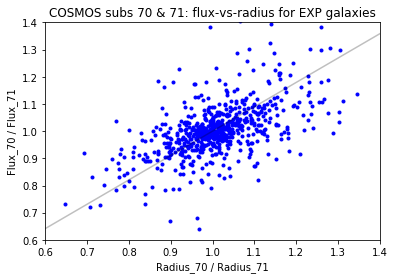

In [18]:
plt.plot(sr, fr, 'b.')
x = np.array([0., 2.])
plt.plot((x-1)*dx+1, (x-1)*dy+1, 'k-', alpha=0.25);
plt.axis([0.6, 1.4, 0.6, 1.4]);
plt.xlabel('Radius_70 / Radius_71')
plt.ylabel('Flux_70 / Flux_71');
plt.title('COSMOS subs 70 & 71: flux-vs-radius for EXP galaxies');
plt.savefig('flux-radius.png');

In [51]:
def matchAll(orig):
    Nexp = []
    Nrex = []
    Mall = [orig.copy()]
    Morig = [orig.copy()]
    for num in range(71, 80):
        print('Set', num)
        # Read catalogs for COSMOS subset "num"
        T = merge_tables([fits_table(fn) for fn in glob('/global/cscratch1/sd/dstn/cosmos-dr7-%i/tractor/*/tractor-*.fits' % num)])
        print(len(T), 'total')
        T.cut(T.brick_primary)
        print(len(T), 'primary')
        T.cut((T.flux_ivar_r > 0) * (T.flux_ivar_g > 0) * (T.flux_ivar_z > 0))
        print(len(T), 'grz')
        T.r_mag = -2.5 * (np.log10(T.flux_r) - 9)
        T.r_sn = T.flux_r * np.sqrt(T.flux_ivar_r)
        # aside
        # Match to subset 70 EXP galaxies of size ~1"
        I,J,d = match_radec(orig.ra, orig.dec, T.ra, T.dec, 1.0/3600., nearest=True)
        print(len(I), 'matched;', Counter(T.type[J]))
        ct = Counter(T.type[J])
        Nexp.append(ct['EXP '])
        Nrex.append(ct['REX '])
        Morig.append(T[J])
        # 
        I,J,d = match_radec(Mall[0].ra, Mall[0].dec, T.ra, T.dec, 1.0/3600., nearest=True)
        # Cut to galaxies classed as EXP
        K = np.flatnonzero(T.type[J] == 'EXP ')
        print(len(K), 'EXP')
        M = T[J[K]]
        # Cut all previous ones to match
        for m in Mall:
            m.cut(I[K])
        Mall.append(M)
    return Nexp, Nrex, Mall, Morig

In [52]:
Nexp, Nrex, Mall, Mx = matchAll(E701.copy())

Set 71
51232 total
50356 primary
46528 grz
853 matched; Counter({'EXP ': 667, 'REX ': 143, 'DEV ': 36, 'PSF ': 6, 'COMP': 1})
667 EXP
Set 72


/global/common/software/desi/cori/desiconda/20180512-1.2.5-img/conda/lib/python3.6/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log10
/global/common/software/desi/cori/desiconda/20180512-1.2.5-img/conda/lib/python3.6/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in log10


51861 total
50931 primary
46181 grz
846 matched; Counter({'EXP ': 665, 'REX ': 145, 'DEV ': 30, 'PSF ': 5, 'COMP': 1})
589 EXP
Set 73
49621 total
48753 primary
45881 grz
853 matched; Counter({'EXP ': 664, 'REX ': 158, 'DEV ': 26, 'PSF ': 5})
544 EXP
Set 74
50334 total
49392 primary
46679 grz
855 matched; Counter({'EXP ': 653, 'REX ': 151, 'DEV ': 39, 'PSF ': 11, 'COMP': 1})
504 EXP
Set 75
49584 total
48686 primary
46166 grz
848 matched; Counter({'EXP ': 644, 'REX ': 155, 'DEV ': 41, 'PSF ': 8})
475 EXP
Set 76
49545 total
48561 primary
45277 grz
838 matched; Counter({'EXP ': 583, 'REX ': 214, 'DEV ': 36, 'PSF ': 5})
438 EXP
Set 77
49009 total
48013 primary
44652 grz
847 matched; Counter({'EXP ': 580, 'REX ': 218, 'DEV ': 39, 'PSF ': 10})
406 EXP
Set 78
47676 total
46672 primary
44355 grz
842 matched; Counter({'EXP ': 542, 'REX ': 256, 'DEV ': 35, 'PSF ': 8, 'COMP': 1})
365 EXP
Set 79
47128 total
46011 primary
42075 grz
816 matched; Counter({'EXP ': 429, 'REX ': 323, 'DEV ': 52, 'PSF ': 

In [53]:
len(Morig), [len(M) for M in Mall]

(875, [288, 288, 288, 288, 288, 288, 288, 288, 288, 288])

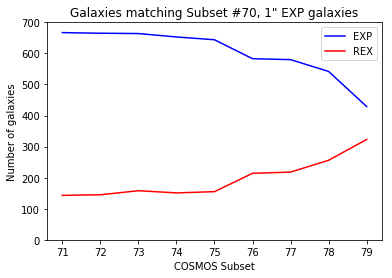

In [54]:
sub = np.arange(71,80);
plt.plot(sub, Nexp, 'b-', label='EXP');
plt.plot(sub, Nrex, 'r-', label='REX');
plt.xlabel('COSMOS Subset')
plt.ylabel('Number of galaxies')
plt.legend()
plt.ylim(0, 700)
plt.title('Galaxies matching Subset #70, 1" EXP galaxies');

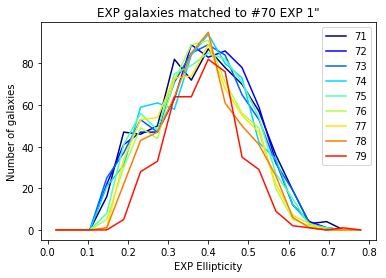

In [67]:
cm = matplotlib.cm.jet
for i,(s,M) in enumerate(zip(np.arange(71,80), Mx[1:])):
    I = (M.type == 'EXP ')
    e = np.hypot(M.shapeexp_e1[I], M.shapeexp_e2[I])
    #plt.hist(e, range=(0,1), bins=20, histtype='step', label='%i'%s)
    #plt.plot(M.shapeexp_e1[I], M.shapeexp_e2[I], 'b.')
    #plt.show()
    n,e = np.histogram(e, bins=np.linspace(0, 0.8, 20))#, normed=True)
    c = cm(i/9.)
    bincenters = (e[1:] + e[:-1])/2.
    plt.plot(bincenters, n, '-', color=c, label='%i'%s)
plt.legend();
plt.xlabel('EXP Ellipticity')
plt.ylabel('Number of galaxies');
plt.title('EXP galaxies matched to #70 EXP 1"')
plt.savefig('ell.png')

In [42]:
E702 = E70[(E70.shapeexp_r > 1.5) * (E70.shapeexp_r < 3)]
len(E702)

604

In [43]:
Nexp2, Nrex2, Mall2, Mx2 = matchAll(E702.copy())

Set 71
51232 total
50356 primary
46528 grz
582 matched; Counter({'EXP ': 517, 'REX ': 38, 'DEV ': 17, 'COMP': 6, 'PSF ': 4})
517 EXP
Set 72


/global/common/software/desi/cori/desiconda/20180512-1.2.5-img/conda/lib/python3.6/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log10
/global/common/software/desi/cori/desiconda/20180512-1.2.5-img/conda/lib/python3.6/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in log10


51861 total
50931 primary
46181 grz
578 matched; Counter({'EXP ': 489, 'REX ': 53, 'DEV ': 28, 'COMP': 4, 'PSF ': 4})
456 EXP
Set 73
49621 total
48753 primary
45881 grz
589 matched; Counter({'EXP ': 509, 'REX ': 48, 'DEV ': 21, 'COMP': 7, 'PSF ': 4})
430 EXP
Set 74
50334 total
49392 primary
46679 grz
589 matched; Counter({'EXP ': 515, 'REX ': 55, 'DEV ': 14, 'COMP': 3, 'PSF ': 2})
415 EXP
Set 75
49584 total
48686 primary
46166 grz
585 matched; Counter({'EXP ': 502, 'REX ': 53, 'DEV ': 20, 'PSF ': 6, 'COMP': 4})
396 EXP
Set 76
49545 total
48561 primary
45277 grz
568 matched; Counter({'EXP ': 493, 'REX ': 55, 'DEV ': 13, 'PSF ': 5, 'COMP': 2})
381 EXP
Set 77
49009 total
48013 primary
44652 grz
578 matched; Counter({'EXP ': 505, 'REX ': 52, 'DEV ': 13, 'PSF ': 6, 'COMP': 2})
374 EXP
Set 78
47676 total
46672 primary
44355 grz
582 matched; Counter({'EXP ': 495, 'REX ': 68, 'DEV ': 10, 'PSF ': 8, 'COMP': 1})
366 EXP
Set 79
47128 total
46011 primary
42075 grz
568 matched; Counter({'EXP ': 466

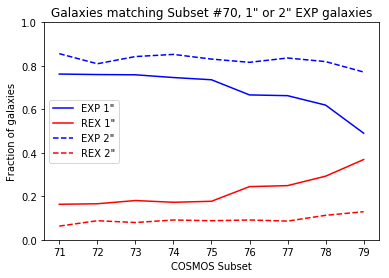

In [48]:
sub = np.arange(71,80);
plt.plot(sub, np.array(Nexp) / len(E701), 'b-', label='EXP 1"');
plt.plot(sub, np.array(Nrex) / len(E701), 'r-', label='REX 1"');
plt.plot(sub, np.array(Nexp2) / len(E702), 'b--', label='EXP 2"');
plt.plot(sub, np.array(Nrex2) / len(E702), 'r--', label='REX 2"');
plt.xlabel('COSMOS Subset')
plt.ylabel('Fraction of galaxies')
plt.legend()
plt.ylim(0, 1)
plt.title('Galaxies matching Subset #70, 1" or 2" EXP galaxies');
plt.savefig('exp-to-rex.png')

In [31]:
# Now drill down on some example galaxies.
i1 = np.argmin(np.abs(E70.shapeexp_r - 0.75) + np.abs(E70.r_sn - 20)/20)
i2 = np.argmin(np.abs(E70.shapeexp_r - 2.) + np.abs(E70.r_sn - 40)/20)

print(E70.shapeexp_r[i1], E70.r_sn[i1], E70.r_mag[i1])
print(E70.shapeexp_r[i2], E70.r_sn[i2], E70.r_mag[i2])

0.753367 19.9602 21.8254
2.02783 39.8252 20.1742


In [43]:
from legacypipe.survey import LegacySurveyData
from legacypipe.catalog import read_fits_catalog
from legacypipe.survey import wcs_for_brick
from legacypipe.runcosmos import DecamImagePlusNoise
from tractor import Tractor
survey = survey70 = LegacySurveyData('/global/cscratch1/sd/dstn/cosmos-dr7-70')
allsurvey = LegacySurveyData('/global/cscratch1/sd/dstn/dr7-cosmos/')
allsurvey.image_typemap.update({'decam+noise' : DecamImagePlusNoise})

In [44]:
def get_sampler(i, j):
    brickname = E70.brickname[i]
    catsrc = E70[i]
    src = read_fits_catalog(E70[np.array([i])])[0]

    bx,by = int(np.round(catsrc.bx)), int(np.round(catsrc.by))

    jpeg = plt.imread(survey.find_file('image-jpeg', brick=brickname))
    jpeg = np.flipud(jpeg)
    sz = 20
    plt.imshow(jpeg[by-sz:by+sz+1, bx-sz:bx+sz+1,:], interpolation='nearest', origin='lower')
    plt.savefig('gal%i.png' % (j))
    plt.show()
    ccds = fits_table(survey.find_file('ccds-table', brick=brickname))
    ccds.cut((ccds.brick_x0 < (bx+sz)) * (ccds.brick_x1 > (bx-sz)) *
             (ccds.brick_y0 < (by+sz)) * (ccds.brick_y1 > (by-sz)))
    class fakebrick(object):
        pass
    b = fakebrick()
    b.ra = catsrc.ra
    b.dec = catsrc.dec
    targetwcs = wcs_for_brick(b, W=2*sz+1, H=2*sz+1)
    H,W = targetwcs.shape
    targetrd = np.array([targetwcs.pixelxy2radec(x,y) for x,y in
                        [(1,1),(W,1),(W,H),(1,H),(1,1)]])
    # "allsurveys" has the calib files, etc, but has all COSMOS subsets.  Cut to just the subset in 'ccds'.
    C = allsurvey.ccds_touching_wcs(targetwcs)
    goodccds = set([(e,n.strip()) for e,n in zip(ccds.expnum, ccds.ccdname)])
    I, = np.nonzero([(e,n.strip()) in goodccds for e,n in zip(C.expnum, C.ccdname)])
    C.cut(I)

    tims = []
    for c in C:
        im = allsurvey.get_image_object(c)
        tim = im.get_tractor_image(radecpoly=targetrd, pixPsf=True, hybridPsf=True, normalizePsf=True,
                                  splinesky=True)
        tims.append(tim)

    tr = Tractor(tims, [src])
    tr.freezeParam('images')
    nwalkers = 50
    ndim = tr.numberOfParams()
    print('N dims', ndim)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, tr)
    p0 = tr.getParams()
    dlnp,x,alpha,v0 = tr.optimize(variance=True)
    list(zip(src.getParamNames(), p0, np.sqrt(v0)))
    state0 = emcee.utils.sample_ball(p0, np.sqrt(v0), size=nwalkers)
    return sampler, state0

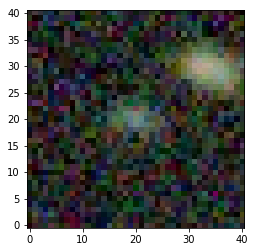

Reading CCDs from /global/cscratch1/sd/dstn/dr7-cosmos/survey-ccds-cosmos.fits.gz
Got 5363 CCDs
Total of 5363 CCDs
Reading image slice: (slice(834, 876, None), slice(1397, 1439, None))
Reading image from /global/cscratch1/sd/dstn/dr7-cosmos/images/decam/NonDECaLS/CP20150218/c4d_150218_045727_ooi_g_v1.fits.fz hdu 48
Reading data quality image /global/cscratch1/sd/dstn/dr7-cosmos/images/decam/NonDECaLS/CP20150218/c4d_150218_045727_ood_g_v1.fits.fz ext 48
Reading merged spline sky models from /global/cscratch1/sd/dstn/dr7-cosmos/calib/decam/splinesky-merged/00411/decam-00411355.fits
Found 1 matching CCDs
Instantiating and subtracting sky model
Reading merged PsfEx models from /global/cscratch1/sd/dstn/dr7-cosmos/calib/decam/psfex-merged/00411/decam-00411355.fits
Found 1 matching CCDs
NORMALIZING PSF!
Using PSF model HybridPixelizedPSF: Gaussian sigma 1.49, Pix NormalizedPixelizedPsfEx
Adding noise: sig1 was 0.00574726755733
Adding 0.00937687
New sig1 is 0.0109980325175
Reading image slice

In [45]:
sampler,state0 = get_sampler(i1, 1)

In [46]:
# Run MCMC -- this takes a few minutes!
state1 = sampler.run_mcmc(state0, 500)

In [48]:
samples = sampler.flatchain[5000:,:]
samples.shape

(20000, 8)

In [ ]:
import corner
fig = corner.corner(samples, labels=['ra','dec','g','r','z','re','e1','e2'])
fig.savefig('triangle1.png')

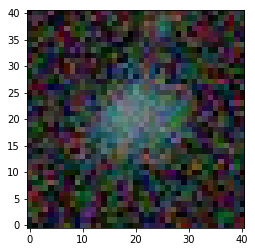

Reading image slice: (slice(424, 466, None), slice(1626, 1668, None))
Reading image from /global/cscratch1/sd/dstn/dr7-cosmos/images/decam/NonDECaLS/CP20150218/c4d_150218_045727_ooi_g_v1.fits.fz hdu 15
Reading data quality image /global/cscratch1/sd/dstn/dr7-cosmos/images/decam/NonDECaLS/CP20150218/c4d_150218_045727_ood_g_v1.fits.fz ext 15
Reading merged spline sky models from /global/cscratch1/sd/dstn/dr7-cosmos/calib/decam/splinesky-merged/00411/decam-00411355.fits
Found 1 matching CCDs
Instantiating and subtracting sky model
Reading merged PsfEx models from /global/cscratch1/sd/dstn/dr7-cosmos/calib/decam/psfex-merged/00411/decam-00411355.fits
Found 1 matching CCDs
NORMALIZING PSF!
Using PSF model HybridPixelizedPSF: Gaussian sigma 1.59, Pix NormalizedPixelizedPsfEx
Adding noise: sig1 was 0.00626846087841
Adding 0.00882008
New sig1 is 0.0108206906743
Reading image slice: (slice(405, 447, None), slice(1645, 1687, None))
Reading image from /global/cscratch1/sd/dstn/dr7-cosmos/images/d

In [50]:
sampler2,state0 = get_sampler(i2, 2)

In [51]:
state2 = sampler2.run_mcmc(state0, 500)

In [52]:
samples2 = sampler2.flatchain[5000:,:]
samples2.shape

(20000, 8)

In [ ]:
fig = corner.corner(samples2, labels=['ra','dec','g','r','z','re','e1','e2'])
fig.savefig('triangle2.png')

In [ ]:
# Look at re vs e=hypot(e1,e2) triangle plot
s2 = samples2[:,:7]
s2[:,6] = np.hypot(samples2[:,-1], samples2[:,-2])
fig = corner.corner(s2, labels=['ra','dec','g','r','z','re','e'])